In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel("market_data.xlsx")
df.head()

,Time (UTC+10),Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions TAS Trading Price ($/MWh),Regions VIC Trading Price ($/MWh),Regions NSW Trading Total Intermittent Generation (MW),Regions SA Trading Total Intermittent Generation (MW),Regions TAS Trading Total Intermittent Generation (MW),Regions VIC Trading Total Intermittent Generation (MW),Regions NSW Operational Demand (MW),Regions SA Operational Demand (MW),Regions TAS Operational Demand (MW),Regions VIC Operational Demand (MW)
0,2018-01-01 00:00:00,88.00,103.11,90.55,90.43,0.18,60.53,121.68,146.87,7100,1398,1091,4599
1,2018-01-01 00:30:00,91.86,107.17,92.28,92.46,0.15,43.07,118.73,131.68,6974,1359,1082,4398
2,2018-01-01 01:00:00,88.83,103.31,87.53,87.62,0.13,41.67,110.48,119.98,6790,1316,1071,4238
3,2018-01-01 01:30:00,73.62,88.20,76.29,73.08,0.14,42.15,120.09,123.86,6536,1240,1067,4112
4,2018-01-01 02:00:00,71.49,85.24,75.10,70.18,0.16,38.31,114.64,132.72,6339,1194,1061,3956


In [3]:
df.shape

(63457, 13)

In [4]:
# test the correlation between variables
df.corr(method ='pearson')

,Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions TAS Trading Price ($/MWh),Regions VIC Trading Price ($/MWh),Regions NSW Trading Total Intermittent Generation (MW),Regions SA Trading Total Intermittent Generation (MW),Regions TAS Trading Total Intermittent Generation (MW),Regions VIC Trading Total Intermittent Generation (MW),Regions NSW Operational Demand (MW),Regions SA Operational Demand (MW),Regions TAS Operational Demand (MW),Regions VIC Operational Demand (MW)
Regions NSW Trading Price ($/MWh),1.000000,0.077953,0.027427,0.308409,-0.023976,-0.019906,-0.014451,-0.018579,0.192090,0.102687,0.102815,0.147621
Regions SA Trading Price ($/MWh),0.077953,1.000000,0.043101,0.731366,-0.042499,-0.054587,-0.019933,-0.086514,0.124717,0.189799,0.067721,0.184057
Regions TAS Trading Price ($/MWh),0.027427,0.043101,1.000000,0.033279,-0.039977,-0.032783,-0.139558,-0.066135,0.093161,0.066488,0.022822,0.060535
Regions VIC Trading Price ($/MWh),0.308409,0.731366,0.033279,1.000000,-0.024659,-0.036233,-0.021473,-0.068917,0.145183,0.177508,0.073671,0.205402
Regions NSW Trading Total Intermittent Generation (MW),-0.023976,-0.042499,-0.039977,-0.024659,1.000000,0.229394,0.304862,0.392491,0.110431,-0.105429,0.109908,0.075691
Regions SA Trading Total Intermittent Generation (MW),-0.019906,-0.054587,-0.032783,-0.036233,0.229394,1.000000,0.218967,0.669005,0.046469,0.160609,0.087847,0.081658
Regions TAS Trading Total Intermittent Generation (MW),-0.014451,-0.019933,-0.139558,-0.021473,0.304862,0.218967,1.000000,0.404265,0.037200,0.061192,0.146857,0.107624
Regions VIC Trading Total Intermittent Generation (MW),-0.018579,-0.086514,-0.066135,-0.068917,0.392491,0.669005,0.404265,1.000000,0.033656,0.041604,0.095227,0.053301
Regions NSW Operational Demand (MW),0.192090,0.124717,0.093161,0.145183,0.110431,0.046469,0.037200,0.033656,1.000000,0.570257,0.642385,0.795891
Regions SA Operational Demand (MW),0.102687,0.189799,0.066488,0.177508,-0.105429,0.160609,0.061192,0.041604,0.570257,1.000000,0.483018,0.727171


select the attributes with correlation greater than 0.2 with 'VIC Trading Price'
<br>Regions NSW Trading Price  
Regions SA Trading Price 
<br>Regions VIC Operational Demand 

In [5]:
# select the atrributes with high correlation to VIC price
selected_df = df[["Time (UTC+10)", "Regions NSW Trading Price ($/MWh)", "Regions SA Trading Price ($/MWh)", "Regions VIC Operational Demand (MW)", "Regions VIC Trading Price ($/MWh)"]]
df2 = selected_df.drop(['Time (UTC+10)'], axis=1)
df2.index = selected_df['Time (UTC+10)']
df2.tail()

,Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions VIC Operational Demand (MW),Regions VIC Trading Price ($/MWh)
Time (UTC+10),,,,
2021-08-14 22:00:00,50.84,59.16,5492,49.93
2021-08-14 22:30:00,66.85,80.01,5344,62.86
2021-08-14 23:00:00,55.64,77.76,5204,32.26
2021-08-14 23:30:00,52.25,76.47,5268,25.10
2021-08-15 00:00:00,48.69,83.68,5244,8.73


## Visualisation

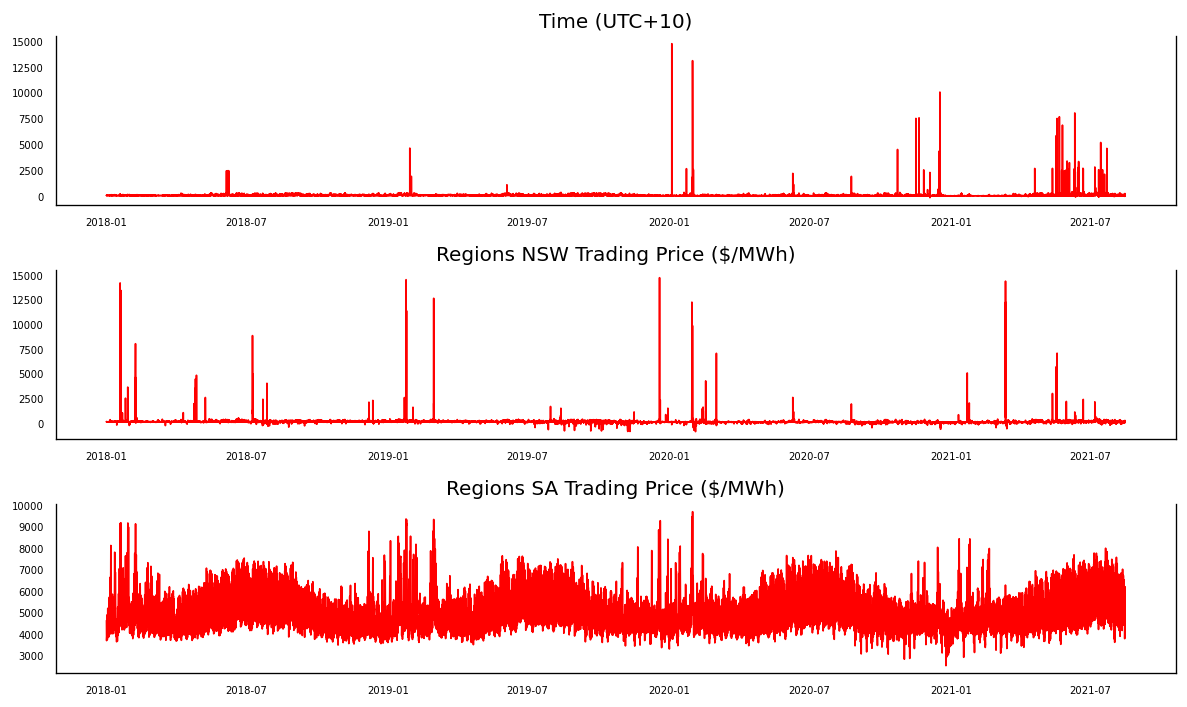

In [6]:
# visualise the variables
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df2[df2.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [7]:
cols = df2.columns
#outlier value treatment
#restrict the max and min to within Q1-20*IQR and Q3+20*IQR
for j in cols:
    Q1 = df2[j].quantile(0.25)
    Q3 = df2[j].quantile(0.75)
    IQR = Q3 - Q1
    for i in range(0,len(df2)):
        if df2[j][i]<(Q1-20*IQR):
            df2[j][i] = Q1-20*IQR
        elif (df2[j][i]>(Q3+20*IQR)):
            df2[j][i] = Q3+20*IQR

In [8]:
# split the dataset
train_data = df2.loc['20180101':'20201231']
cross_data = df2.loc['20210101':'20210630']
test_data = df2.loc['20210701':'20210815']
test_data.head()

,Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions VIC Operational Demand (MW),Regions VIC Trading Price ($/MWh)
Time (UTC+10),,,,
2021-07-01 00:00:00,73.25,102.24,5410,51.71
2021-07-01 00:30:00,190.22,96.47,5192,90.51
2021-07-01 01:00:00,79.17,87.88,5016,73.91
2021-07-01 01:30:00,68.24,102.82,4837,33.79
2021-07-01 02:00:00,72.64,106.60,4661,43.57


In [9]:
nobs = len(test_data)
df_train, df_test = df2[0:-nobs], df2[-nobs:]
df_test.head()

,Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions VIC Operational Demand (MW),Regions VIC Trading Price ($/MWh)
Time (UTC+10),,,,
2021-07-01 00:00:00,73.25,102.24,5410,51.71
2021-07-01 00:30:00,190.22,96.47,5192,90.51
2021-07-01 01:00:00,79.17,87.88,5016,73.91
2021-07-01 01:30:00,68.24,102.82,4837,33.79
2021-07-01 02:00:00,72.64,106.60,4661,43.57


In [10]:
df_test.shape

(2161, 4)

## Test for Stationarity

In [11]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [12]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Regions NSW Trading Price ($/MWh)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.6998
 No. Lags Chosen       = 60
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Regions SA Trading Price ($/MWh)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.5789
 No. Lags Chosen       = 60
 Critical value 1%     = -3.43
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Regions VIC Operational Demand (MW)" 
    ------------------------------------------

All the series are now stationary.

## Parameter Optimisation

In [13]:
# 
model = VAR(df_train)
for i in [10,50,100,150,200,300,400,500]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic, '\n')

Lag Order = 10
AIC :  30.29368035498088
BIC :  30.317826527036146 

Lag Order = 50
AIC :  29.516318556330017
BIC :  29.63476243301424 

Lag Order = 100
AIC :  29.392745214722066
BIC :  29.62921535524509 

Lag Order = 150
AIC :  29.33397668956498
BIC :  29.688644720530874 

Lag Order = 200
AIC :  29.303563715161303
BIC :  29.776601658262727 

Lag Order = 300
AIC :  29.234707997310903
BIC :  29.945003416305532 

Lag Order = 400
AIC :  29.182020035939832
BIC :  30.130265789678894 

Lag Order = 500
AIC :  29.193338359163207
BIC :  30.380230512062017 



Select the order to be 400 as it gives the lowest AIC.

In [14]:
# fit the model to the training set using the selected order
model_fitted = model.fit(400)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 14, Oct, 2021
Time:                     14:01:41
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    30.1303
Nobs:                     60896.0    HQIC:                   29.4764
Log likelihood:      -1.22776e+06    FPE:                4.71641e+12
AIC:                      29.1820    Det(Omega_mle):     4.25138e+12
--------------------------------------------------------------------
Results for equation Regions NSW Trading Price ($/MWh)
                                              coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------------
const                                           -0.671482         1.764389           -0.381           0.704
L1.Regions NSW Trading Price ($/

In [15]:
# get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  

400


In [16]:
# predict the forecast value for the testing set
forecast_input = df_train.values[-lag_order:]
forecast_input

array([[ 115.57,  113.1 , 6210.  ,  145.51],
       [ 125.8 ,  104.34, 6528.  ,  124.99],
       [ 125.73,   91.58, 6793.  ,  115.33],
       ...,
       [  71.81,   95.28, 5653.  ,   67.46],
       [  75.17,   87.72, 5397.  ,   60.16],
       [  80.41,   88.37, 5487.  ,   73.85]])

In [17]:
len(forecast_input)

400

In [18]:
# convert the forecast values into dataframe
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_test.index, columns='Predicted '+df2.columns)
df_forecast

,Predicted Regions NSW Trading Price ($/MWh),Predicted Regions SA Trading Price ($/MWh),Predicted Regions VIC Operational Demand (MW),Predicted Regions VIC Trading Price ($/MWh)
Time (UTC+10),,,,
2021-07-01 00:00:00,59.477504,89.322344,5454.200622,74.935787
2021-07-01 00:30:00,61.425863,78.029602,5268.063437,65.500304
2021-07-01 01:00:00,60.713748,70.886049,5093.926802,57.857966
2021-07-01 01:30:00,60.312239,64.688660,4948.365468,51.478220
2021-07-01 02:00:00,59.481443,66.891054,4772.000265,56.081663
...,...,...,...,...
2021-08-14 22:00:00,67.811314,75.154078,5393.807456,73.821606
2021-08-14 22:30:00,64.450587,69.554137,5198.359682,69.500457
2021-08-14 23:00:00,58.629271,60.882747,5062.570459,62.378713


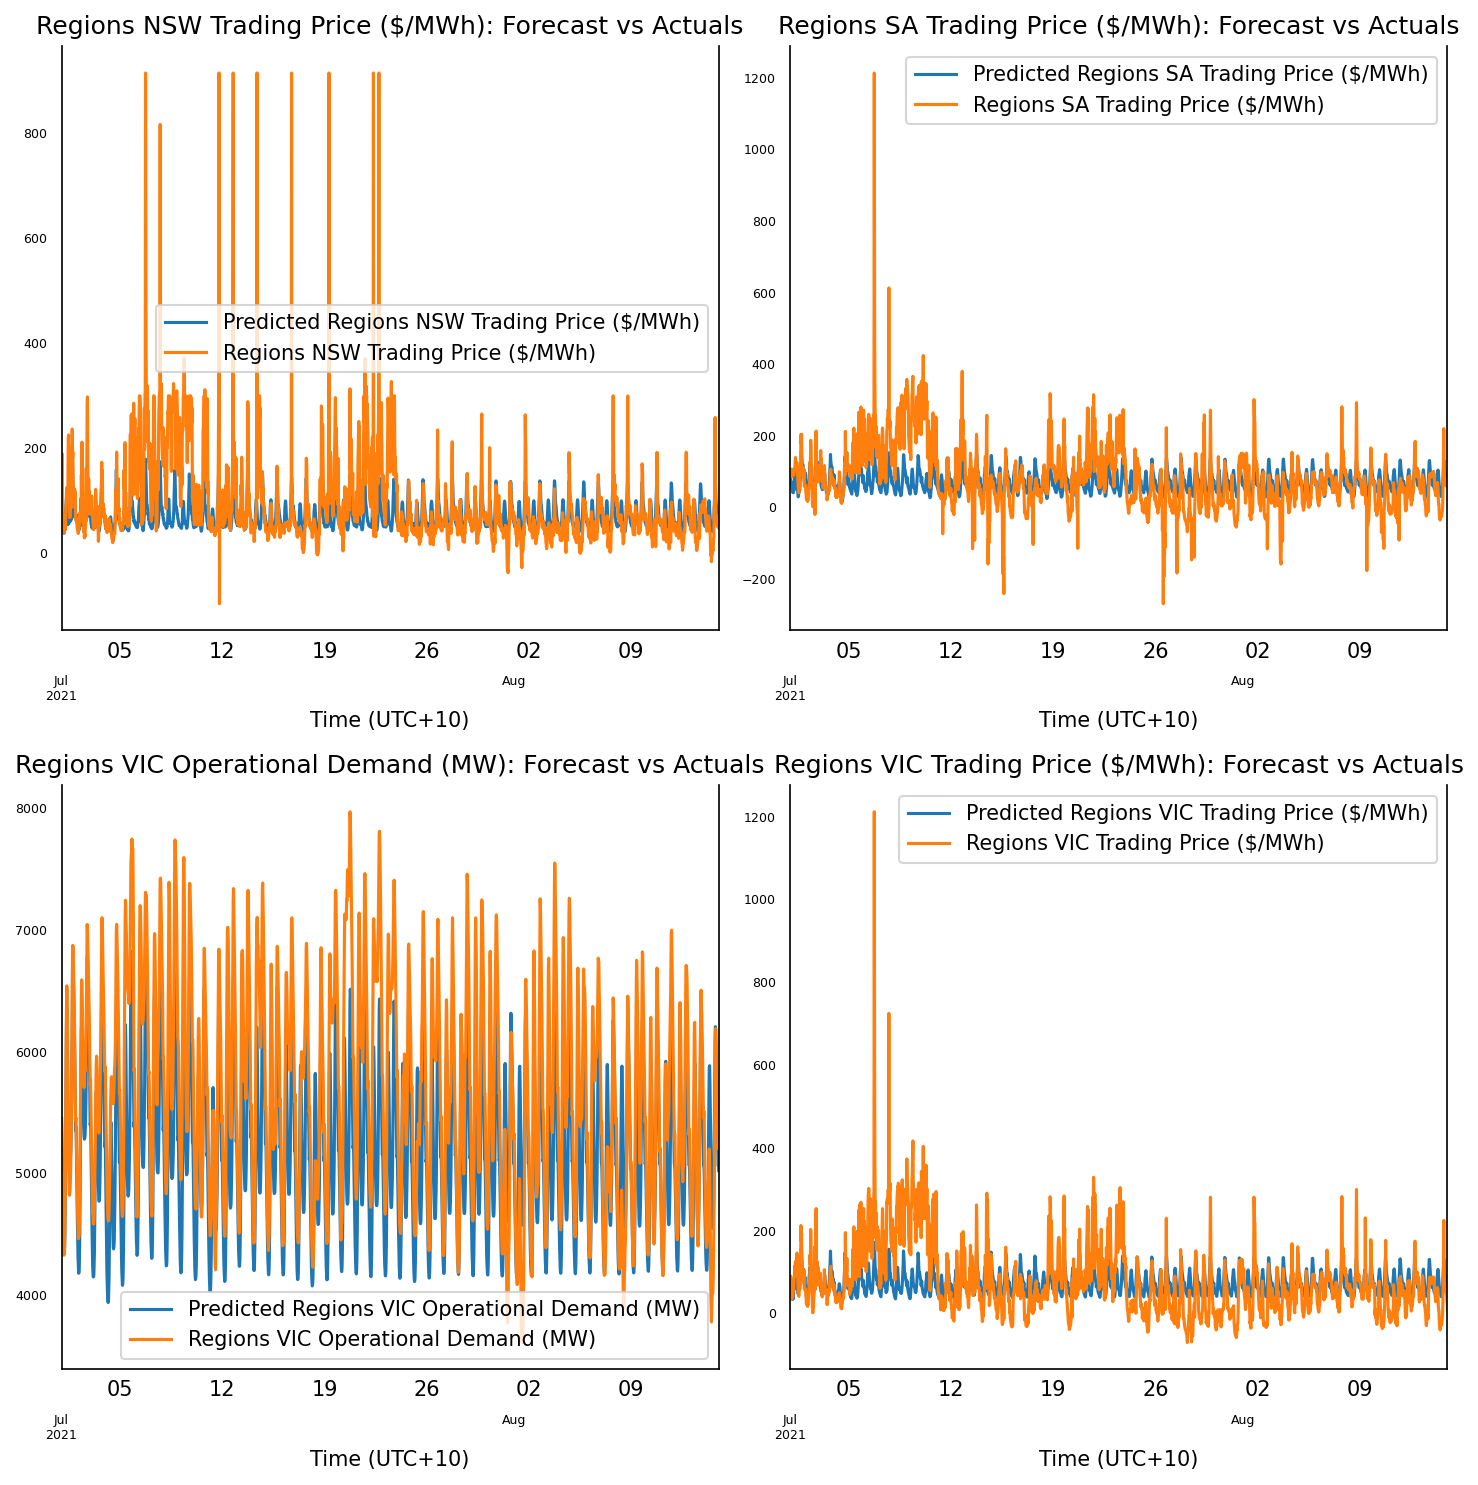

In [19]:
# plot timeserie graphs with the actual value vs the predictions
fig, axes = plt.subplots(nrows=int(len(df2.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df2.columns, axes.flatten())):
    df_forecast['Predicted '+col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

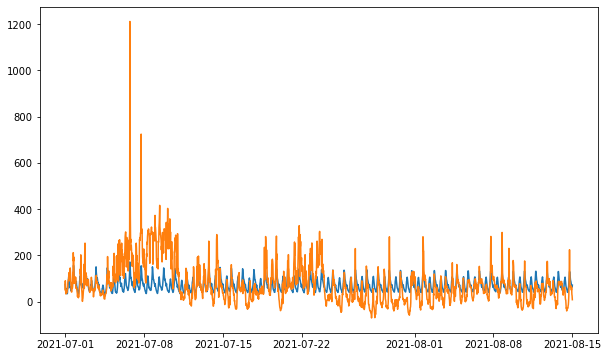

In [20]:
# plot the VIC Price of actual vs predicted values
plt.figure(figsize=(10,6))
plt.plot(df_forecast["Predicted Regions VIC Trading Price ($/MWh)"])
plt.plot(df_test["Regions VIC Trading Price ($/MWh)"][-nobs:])
plt.show()

## Model Accuracy

In [21]:
def adjust(val, length= 6): return str(val).ljust(length)

In [22]:
# test the accuracy of the predicted price
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Regions VIC Trading Price ($/MWh)')
accuracy_prod = forecast_accuracy(df_forecast['Predicted Regions VIC Trading Price ($/MWh)'].values, df_test['Regions VIC Trading Price ($/MWh)'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: Regions VIC Trading Price ($/MWh)
mape   :  3.6921
me     :  -5.4222
mae    :  53.9997
mpe    :  0.5989
rmse   :  79.2913
corr   :  0.4587
minmax :  0.5485


## Cross Validation

In [25]:
model2 = VAR(df_train)

In [26]:
cross_data.head()

,Regions NSW Trading Price ($/MWh),Regions SA Trading Price ($/MWh),Regions VIC Operational Demand (MW),Regions VIC Trading Price ($/MWh)
Time (UTC+10),,,,
2021-01-01 00:00:00,43.29,42.50,4555,43.48
2021-01-01 00:30:00,38.04,35.72,4396,37.21
2021-01-01 01:00:00,38.10,34.56,4252,36.37
2021-01-01 01:30:00,32.26,24.71,4137,25.02
2021-01-01 02:00:00,32.45,14.23,3976,14.60


In [27]:
len(cross_data)

8688

In [28]:
X = cross_data[["Regions NSW Trading Price ($/MWh)", "Regions SA Trading Price ($/MWh)", "Regions VIC Operational Demand (MW)"]]
y = cross_data[["Regions VIC Trading Price ($/MWh)"]]
tscv = TimeSeriesSplit()
print(tscv)
TimeSeriesSplit(max_train_size=None, n_splits=10)
for train_index, test_index in tscv.split(X):
    print(train_index) 
    print("\n")
    print(test_index)

TimeSeriesSplit(max_train_size=None, n_splits=5)
[   0    1    2 ... 1445 1446 1447]


[1448 1449 1450 ... 2893 2894 2895]
[   0    1    2 ... 2893 2894 2895]


[2896 2897 2898 ... 4341 4342 4343]
[   0    1    2 ... 4341 4342 4343]


[4344 4345 4346 ... 5789 5790 5791]
[   0    1    2 ... 5789 5790 5791]


[5792 5793 5794 ... 7237 7238 7239]
[   0    1    2 ... 7237 7238 7239]


[7240 7241 7242 ... 8685 8686 8687]


In [29]:
# reference from https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4
from math import sqrt
tscv = TimeSeriesSplit(n_splits = 10)
rmse = []
for train_index, test_index in tscv.split(cross_data):
    cv_train, cv_test = cross_data.iloc[train_index], cross_data.iloc[test_index]
    #print(train_index) 
    #print(test_index)
    #arma = sm.tsa.ARMA(cv_train, (2,2)).fit(disp=False)
    model2 = VAR(cv_train)
    #predictions = arma.predict(cv_test.index.values[0], cv_test.index.values[-1])
    fc2 = model_fitted.forecast(y=forecast_input, steps=len(cv_test))
    df_forecast2 = pd.DataFrame(fc2, index=cv_test.index, columns=df2.columns)
    cv_result = np.array(df_forecast2["Regions VIC Trading Price ($/MWh)"])
    
    true_values = cv_test["Regions VIC Trading Price ($/MWh)"].values
    rmse.append(sqrt(mean_squared_error(true_values, cv_result)))
    
print("RMSE: {}".format(np.mean(rmse)))

RMSE: 73.36152844229379


## Revenue Maximisation

In [30]:
import copy

In [31]:
df['Time (UTC+10)'] = pd.to_datetime(df['Time (UTC+10)'])

In [32]:
# select the price column
df_price = df[["Time (UTC+10)","Regions VIC Trading Price ($/MWh)"]]
df_price.head()

,Time (UTC+10),Regions VIC Trading Price ($/MWh)
0,2018-01-01 00:00:00,90.43
1,2018-01-01 00:30:00,92.46
2,2018-01-01 01:00:00,87.62
3,2018-01-01 01:30:00,73.08
4,2018-01-01 02:00:00,70.18


In [33]:
## spliting dataset into 3 categories 
train = df_price.loc[(df_price["Time (UTC+10)"] < "2021-01-01 00:00:00" )]
cross = df_price.loc[(df_price["Time (UTC+10)"] >= "2021-01-01 00:00:00" )& (df_price["Time (UTC+10)"] < "2021-07-01 00:00:00" )]
test = df_price.loc[(df_price["Time (UTC+10)"] >= "2021-07-01 00:00:00" )]
test

,Time (UTC+10),Regions VIC Trading Price ($/MWh)
61296,2021-07-01 00:00:00,51.71
61297,2021-07-01 00:30:00,90.51
61298,2021-07-01 01:00:00,73.91
61299,2021-07-01 01:30:00,33.79
61300,2021-07-01 02:00:00,43.57
...,...,...
63452,2021-08-14 22:00:00,49.93
63453,2021-08-14 22:30:00,62.86
63454,2021-08-14 23:00:00,32.26
63455,2021-08-14 23:30:00,25.10


In [34]:
time = list(df_forecast.index)
fc_price = df_forecast["Predicted Regions VIC Trading Price ($/MWh)"].to_list()

In [35]:
d = {'Time (UTC+10)':time,'Predicted Regions VIC Trading Price ($/MWh)':fc_price}

In [36]:
predict = pd.DataFrame(d)
predict

,Time (UTC+10),Predicted Regions VIC Trading Price ($/MWh)
0,2021-07-01 00:00:00,74.935787
1,2021-07-01 00:30:00,65.500304
2,2021-07-01 01:00:00,57.857966
3,2021-07-01 01:30:00,51.478220
4,2021-07-01 02:00:00,56.081663
...,...,...
2156,2021-08-14 22:00:00,73.821606
2157,2021-08-14 22:30:00,69.500457
2158,2021-08-14 23:00:00,62.378713
2159,2021-08-14 23:30:00,67.971122


In [37]:
## convert into numpy array
train = train["Regions VIC Trading Price ($/MWh)"].to_numpy()
cross = cross["Regions VIC Trading Price ($/MWh)"].to_numpy()
test = test["Regions VIC Trading Price ($/MWh)"].to_numpy()
predict = predict["Predicted Regions VIC Trading Price ($/MWh)"].to_numpy()

In [38]:
## helper functions 
## df is the price list, index is the index of df, n is the length of the subsection of the df
## try to implement as many of them thats suited as much distribution of battery as possible
## this solution works better if there are  multiple local min or max within the time frame
def compute_optimal_buyout(df, index, n, df2):
    ## buyout refers to the dict which will be modified in the process as an output
    df_segment = df[index: index+n]
    df_segment2 = df2[index: index+n]
    
    buyout = {}
    ## contrust dictionary
    for i in range(0,len(df_segment)):
        buyout[i] = [df_segment[i],0,df_segment2[i]] 

    ## sort dictionary
    temp = copy.deepcopy(buyout)
    sorted_buyout = {}
    sorted_keys = sorted(buyout, key=buyout.get)
    for i in sorted_keys:
        sorted_buyout[i] = temp[i]
    constraint = [644.4] * n
    ## now find profitable trade deals, and lastly apply contraint
    for i in sorted_buyout:
        remaining = 150
        if sorted_buyout[i][0] * 1.33 > max(df_segment):
            break
        ## for each min price, if you see a profitable price, do something
        for j in range(i, n):
            if remaining <= 0:
                break
            if (sorted_buyout[i][0] * 1.33 < sorted_buyout[j][0] and sorted_buyout[i][0] >= 0 and sorted_buyout[i][1] <= 0) or \
                (sorted_buyout[i][0] < 0 and sorted_buyout[i][0] / 1.5 < sorted_buyout[j][0] and sorted_buyout[i][1] <= 0):
                index = j
                temp = j
                ## check if near solution has a immediate better solution from the next 2 time, and repeat if there are
                while(index< n-2):
                    
                    if max(sorted_buyout[index+1][0],sorted_buyout[index+2][0]) > sorted_buyout[index][0]:
                        if sorted_buyout[index+1][0] < sorted_buyout[index+2][0]:
                            temp = index + 2
                        else:
                            temp = index + 1
                        index = index + 2
                ## index is now the optimal price(can be changed later!) and now commence buyout and record it in buyout dict
                    else:
                        break
                index = temp
                
                remaining_dispatch = 135 - sorted_buyout[index][1]
                
                ## apply contraint, check and use the most contraint varaibled
                ## remain is the max amount you can buy from the buy point
                ## remain dispatch is the max amount you can sell from the sell point
                ## hardcap is the max amount you can buy due to the limit of capacity

                hardcap = min(150, remaining_dispatch/0.81,remaining)
                ## contraint list tracks all of the capacity during the timeframe
                ## if your deals makes any element fall below 0, the deal need to be restricted. 
                for k in range(i,index + 1):
                    if constraint[k] <= 0:
                        hardcap = 0
                    elif (constraint[k] - min(150, remaining_dispatch/0.81,remaining) < 0) and constraint[k] >0:
                        hardcap = min(hardcap, constraint[k])
                
                for k in range(i,index + 1):
                    constraint[k] = constraint[k] - hardcap
                        
                remaining_dispatch = min(hardcap * 0.81,remaining * 0.81)
                    
                ## using the amount that you can buy, fill in the rest of the buyout
                if remaining_dispatch >= 150 * 0.81:
                    buyout[index][1] += 150 * 0.81

                else:
                    buyout[index][1] = min(135,buyout[index][1] + remaining_dispatch)
                
                ##buyout[i][1] = sorted_buyout[i][1] + (buyout[index][1] - sorted_buyout[index][1]) / 0.81
                buyout[i][1] = sorted_buyout[i][1] - (buyout[index][1] - sorted_buyout[index][1]) / 0.81

                
                ##remaining =  remaining - (buyout[i][1] - sorted_buyout[i][1])
                remaining =  remaining - (-buyout[i][1] + sorted_buyout[i][1])

                sorted_buyout[i][1] = buyout[i][1]
                sorted_buyout[index][1] = buyout[index][1]
                
    
            
            
            
    last_buyout_index = 0
    for i in buyout:
        if buyout[i][1] > 0:
            last_buyout_index = i
    return [last_buyout_index,buyout,constraint]

In [39]:
## this version works better where there are 1 centered local min and max in the time frame 
def compute_optimal_buyout_v2(df, index, n, df2):
    ## buyout refers to the dict which will be modified in the process as an output
    df_segment = df[index: index+n]
    df_segment2 = df2[index: index+n]
    buyout = {}
    ## contrust dictionary
    for i in range(0,len(df_segment)):
        buyout[i] = [df_segment[i],0,df_segment2[i]] 

    ## sort dictionary
    temp = copy.deepcopy(buyout)
    sorted_buyout = {}
    sorted_buyout_max = {}
    sorted_keys = sorted(buyout, key=buyout.get)
    sorted_keys_rev = sorted(buyout, key=buyout.get,reverse = True)
    for i in sorted_keys:
        sorted_buyout[i] = temp[i]
    for i in sorted_keys_rev:
        sorted_buyout_max[i] = temp[i]
    constraint = [644.4] * n
    ## now find profitable trade deals, and lastly apply contraint
    for i in sorted_buyout:
        remaining = 150
        if sorted_buyout[i][0] * 1.33 > max(df_segment):
            break
        for j in sorted_buyout_max:
            if remaining <= 0:
                break
            if ((sorted_buyout[i][0] * 1.33 < sorted_buyout[j][0] and sorted_buyout[i][0] >= 0 and sorted_buyout[i][1] <= 0) or \
                (sorted_buyout[i][0] < 0 and sorted_buyout[i][0] / 1.5 < sorted_buyout[j][0] and sorted_buyout[i][1] <= 0)) and j > i:
                index = j
                
                remaining_dispatch = 135 - sorted_buyout[index][1]
                
                ## apply contraint 
                hardcap = min(150, remaining_dispatch/0.81,remaining)
                
                for k in range(i,index + 1):
                    if constraint[k] <= 0:
                        hardcap = 0
                    elif (constraint[k] - min(150, remaining_dispatch/0.81,remaining) < 0) and constraint[k] >0:
                        hardcap = min(hardcap, constraint[k])
                
                for k in range(i,index + 1):
                    constraint[k] = constraint[k] - hardcap
                        
                remaining_dispatch = min(hardcap * 0.81,remaining * 0.81)
                    
                    
                if remaining_dispatch >= 150 * 0.81:
                    buyout[index][1] += 150 * 0.81

                else:
                    buyout[index][1] = min(135,buyout[index][1] + remaining_dispatch)
                
                ##buyout[i][1] = sorted_buyout[i][1] + (buyout[index][1] - sorted_buyout[index][1]) / 0.81
                buyout[i][1] = sorted_buyout[i][1] - (buyout[index][1] - sorted_buyout[index][1]) / 0.81

                
                ##remaining =  remaining - (buyout[i][1] - sorted_buyout[i][1])
                remaining =  remaining - (-buyout[i][1] + sorted_buyout[i][1])

                sorted_buyout[i][1] = buyout[i][1]
                sorted_buyout[index][1] = buyout[index][1]
                
    
            
            
            
    last_buyout_index = 0
    for i in buyout:
        if buyout[i][1] > 0:
            last_buyout_index = i
    return [last_buyout_index,buyout]

In [40]:
## using combination of all algorithm to find the best choice in the context
## add other model you think will benefit the algorithm in this part!
def emsemble_optimal_buyout(df, index, n, df2):
    model1 = compute_optimal_buyout(df, index, n, df2)
    model2 = compute_optimal_buyout_v2(df, index, n, df2)
    dict1 = model1[1]
    dict2 = model2[1]
    if compute_profit(dict1) > compute_profit(dict2):
        return model1
    else:
        return model2

In [41]:
## the main function that compute the total profit, capacity and power usage
def main_function(df, df2):
    total_profit = 0
    n = 0
    capacity = 0
    capacityy = []
    power = []
    while (n < len(df)):
        parameter = 48 - n % 24
        output = emsemble_optimal_buyout(df, n, min(parameter, len(df)-n), df2)
        ## recompute parameter if the there are price brought at the last lookout
        
        if output[0] == parameter - 1:
            index = n+parameter-1
            if index + 1 < len(df):
                while df[index+1] > df[index] and index+1 < len(df):
                    index += 1
                output = emsemble_optimal_buyout(df, n, index - n + 1, df2)
        n += output[0] +1
        total_profit += compute_profit(output[1])
        
        ## compute capacity and power during the timeframe 
        for i in output[1]:
            if output[1][i][1] < 0 and i < output[0] + 1:
                capacity += -output[1][i][1] * 0.9
                power.append(output[1][i][1] * 2)
                capacityy.append(capacity)
            elif output[1][i][1] >= 0 and i <output[0] + 1:
                capacity = capacity - output[1][i][1] / 0.9
                power.append(output[1][i][1] / 0.9 * 2)
                capacityy.append(capacity)


    return [capacityy, power,total_profit]
    

In [42]:
## buyout will be a dict that has value [price, amount]
def compute_profit(buyout):
    profit = 0
    for buy in buyout:
        if buyout[buy][1] < 0:
            profit += buyout[buy][2] * buyout[buy][1] /0.991
        else:
            profit += buyout[buy][2] * buyout[buy][1] * 0.991
    return profit

In [43]:
# use the predict price to evaluate the optimal buyout time and calc the maximum revenue using the actual price 
d = main_function(predict, test)

d[2]

4385836.126121124